# CMLS - Homework 1 - Assignment 4

Link utili:
* [Paper](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf) di riferimento
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) in SKLearn
* [Urbansound8K](https://urbansounddataset.weebly.com/urbansound8k.html) documentation
* [Code example](https://towardsdatascience.com/urban-sound-classification-with-librosa-nuanced-cross-validation-5b5eb3d9ee30)

In [2]:
import numpy as np
import librosa
import os
import scipy as sp
%matplotlib inline

from tqdm import tqdm
import pickle # to save the object as a file
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import IPython.display as ipd
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats
import seaborn as sns
import csv
from tqdm import tqdm   #to monitor loops during computation

In [3]:
n_mfcc = 25

class Sound:
    
    def __init__(self, path, slice_file_name, fold, classID, class_name, startTime, endTime):
        self.slice_file_name = path +'/fold'+fold+'/'+slice_file_name
        self.fold = fold
        self.classID = int(classID)
        self.class_name = class_name
        self.startTime = startTime
        self.endTime = endTime
        self.features = None
        self.mfcc = None
        self.chroma = None
        self.spec_con = None
        
    def extract_features(self):
        audio, fs = librosa.load(self.slice_file_name, sr=None)
        #audio = audio[0:4*fs]
        mfcc = compute_mfcc(audio,fs, n_mfcc)
        self.mfcc = np.mean(mfcc, axis=1)
        #mfcc = librosa.feature.mfcc(y = audio, sr = fs, n_mfcc = n_mfcc)
        chroma_matrix = librosa.feature.chroma_stft(audio, fs)
        self.chroma = np.mean(chroma_matrix, axis=1)
        spec_con = librosa.feature.spectral_contrast(y=audio, sr=fs, n_bands=3)
        self.spec_con = spec_con.mean(axis=1)
        self.features = np.concatenate((np.mean(mfcc, axis=1),np.std(mfcc, axis=1), np.mean(chroma_matrix, axis=1), chroma_matrix.std(axis=1), spec_con.mean(axis=1), spec_con.std(axis=1)),axis =0)
        

In [4]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal 
    X = np.abs(librosa.stft(
    audio,
    window='hamming',
    n_fft = 1024,
    hop_length = 512,
    ))
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr = fs,
        n_fft = 1024,
        n_mels = 40,
        fmin = 0,
        fmax = 22050
        #fmin = 133.33, #standard value
        #fmax = 6853.8
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X) 
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc + 1]
    
    return mfcc


In [5]:
def compute_training_set(test_folder):
    train_files = [s for s in soundList if s.fold!=test_folder]
    n_train_samples = len(train_files)
    train_features = np.zeros((n_train_samples, 82))
    train_labels = []
    
    for i,f in enumerate(train_files):
        #feature_matrix = np.vstack(train_files[i].features)
        #train_features[i,:] = feature_matrix
        train_features[i,:] = train_files[i].features
        train_labels.append(train_files[i].classID)
        
    return [train_features, train_labels]

def compute_test_set(test_folder):
    test_files = [s for s in soundList if s.fold==test_folder]
    n_test_samples = len(test_files)
    test_features = np.zeros((n_test_samples, 82))
    test_labels = []
    
    for i,f in enumerate(test_files):
        #feature_matrix = np.vstack(train_files[i].features)
        #test_features[i,:] = feature_matrix
        test_features[i,:] = test_files[i].features
        test_labels.append(test_files[i].classID)
    
    return [test_features, test_labels]


Read CSV & extract features:

In [6]:
classes = ['air_conditioner',
           'car_horn',
           'children_playing',
           'dog_bark',
           'drilling',
           'engine_idling',
           'gun_shot',
           'jackhammer',
           'siren',
           'street_music'
          ]

In [7]:
path = '../input/urbansound8k/UrbanSound8K.csv'
soundList = []
with open(path, newline='') as soundcsv:
        reader = csv.DictReader(soundcsv)
        totalrows = 8733 #sum(1 for row in reader) # ma non so perchè non funziona
        for row in tqdm(reader, total=totalrows):
        #for row in reader: #old
            s = Sound('../input/urbansound8k', row['slice_file_name'], row['fold'], row['classID'], row['class'], row['start'], 
                      row['end'])
            s.extract_features()
            soundList.append(s)


  1%|▏         | 122/8733 [00:16<20:05,  7.14it/s]/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
  7%|▋         | 626/8733 [01:32<20:14,  6.68it/s]/opt/conda/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
100%|█████████▉| 8732/8733 [19:12<00:00,  7.58it/s] 


Save the featurese in a file for a faster loading

In [ ]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
with open("./soundList_" + dt_string + ".cmls", "wb") as f:
    pickle.dump(soundList, f)

Load the features


In [ ]:
soundList = []
path_to_load = '../input/cmls-homework/soundList_22_04_2021__10_48_25.cmls' #cambia path
with open(path_to_load, 'rb') as soundList_file: 
    soundList = pickle.load(soundList_file)
    # After config_dictionary is read from file
    # print(soundList)

## Visualization

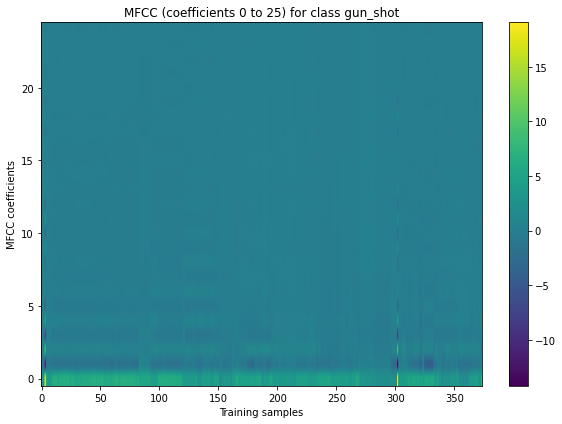

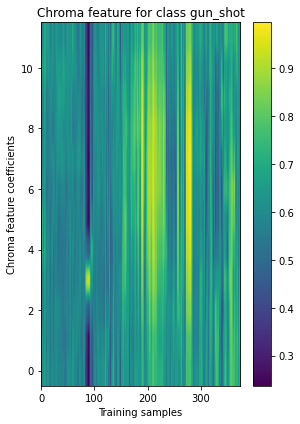

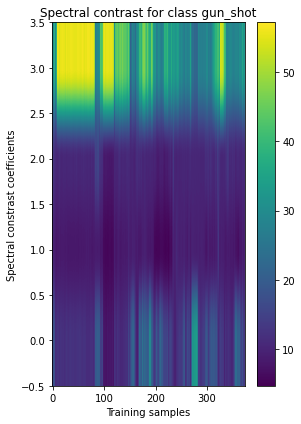

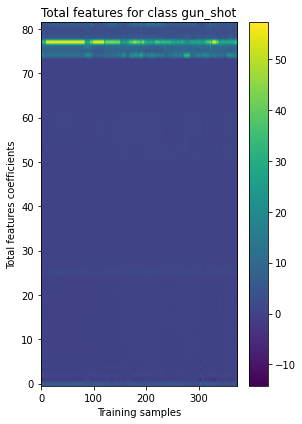

In [21]:
## visualization
for c in classes:
    if c == 'gun_shot':
        mfcc = [s.mfcc for s in soundList if s.class_name==c]
        mfcc = np.array(mfcc).transpose()
        # Visualization
        fig = plt.figure(figsize=(16, 6))
        plt.subplot(1,2,1)
        plt.imshow(mfcc, origin='lower', aspect='auto')
        plt.xlabel('Training samples')
        plt.ylabel('MFCC coefficients')
        plt.title('MFCC (coefficients 0 to 25) for class {}'.format(c))
        plt.colorbar()
        plt.tight_layout()
        ''''
        mfcc_upper = mfcc[4:]
        plt.subplot(1,2,2)
        plt.imshow(mfcc_upper, origin='lower', aspect='auto')
        plt.title('MFCC (coefficients 4 to 25) for class {}'.format(c))
        plt.xlabel('Training samples')
        plt.ylabel('MFCC coefficients')
        plt.colorbar()
        plt.tight_layout()
        '''
        
        chroma = [s.chroma for s in soundList if s.class_name==c]
        chroma = np.array(chroma).transpose()
        # Visualization
        fig = plt.figure(figsize=(16, 6))
        plt.subplot(1,4,2)
        plt.imshow(chroma, origin='lower', aspect='auto')
        plt.xlabel('Training samples')
        plt.ylabel('Chroma feature coefficients')
        plt.title('Chroma feature for class {}'.format(c))
        plt.colorbar()
        plt.tight_layout()
        
        spec_con = [s.spec_con for s in soundList if s.class_name==c]
        spec_con = np.array(spec_con).transpose()
        # Visualization
        fig = plt.figure(figsize=(16, 6))
        plt.subplot(1,4,3)
        plt.imshow(spec_con, origin='lower', aspect='auto')
        plt.xlabel('Training samples')
        plt.ylabel('Spectral constrast coefficients')
        plt.title('Spectral contrast for class {}'.format(c))
        plt.colorbar()
        plt.tight_layout()
        
        
        feat = [s.features for s in soundList if s.class_name==c]
        feat = np.array(feat).transpose()
        fig = plt.figure(figsize=(16, 6))
        plt.subplot(1,4,4)
        plt.imshow(feat, origin='lower', aspect='auto')
        plt.xlabel('Training samples')
        plt.ylabel('Total features coefficients')
        plt.title('Total features for class {}'.format(c))
        plt.colorbar()
        plt.tight_layout()
        

Training with cross-validation (10 folds)

In [ ]:
#debug
'''
import random
accuracy = []
precision= []
recall = []
F1_score = []

for i in np.arange(1,10):
    [acc, pr, rec, f1s] = random.sample(range(1, 100), 4)
    accuracy.append(acc)
    precision.append(pr)
    recall.append(rec)
    F1_score.append(f1s)

print(accuracy)
'''

In [8]:
def compute_cm_multiclass(gt, predicted):   
    classes = np.unique(gt)
    #print("classes: ", classes)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        #print("pred_class", pred_class)
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    return CM

Normalize Features ?

In [ ]:
'''
for c in classes: 
    idx_c = [i for i, s in enumerate(soundList) if s.class_name==c]
    print(c)
    X_c = [s.features for s in soundList if s.class_name==c]
    # Normalize Features 
    feat_max = np.max(X_c, axis=0)
    feat_min = np.min(X_c, axis=0)
    X_c_normalized = (X_c - feat_min) / (feat_max - feat_min)
        
    for i in np.arange(len(idx_c)): 
        soundList[idx_c[i]].features = X_c_normalized[i]
'''

In [ ]:
from sklearn.preprocessing import StandardScaler
k = 10

# Metrics
cm_multiclass = np.zeros((len(classes), len(classes)))
accuracy = 0

SVM_parameters = {
    'C': 1,
    'kernel': 'rbf',
}

model = sklearn.svm.SVC(**SVM_parameters, probability=True)


## Main FOR cycle
for i in tqdm(np.arange(1,k+1)):
    [X_train, y_train] = compute_training_set(str(i))
    #print("Size of train_features ",i,X_train.shape)
    #print("Size of train_labels ",i,len(y_train))
    [X_test, y_test] = compute_test_set(str(i))
    #print("Size of test_features ",i,X_test.shape)
    
    ss = StandardScaler(copy=True)
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    # Train model
    #model = sklearn.svm.SVC(**SVM_parameters)
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    
    #y_test_predicted = np.array(y_test_predicted, dtype=np.int)
    #print("PREDICTIONS ON FOLD",i, y_test_predicted)
    cm_multiclass += compute_cm_multiclass(y_test, y_test_predicted)
    accuracy += accuracy_score(y_test, y_test_predicted)

#cm_multiclass /= k

print(cm_multiclass)

#Average accuracy
accuracy /= k
print("Average accuracy: ", accuracy)

Plot confusion matrix using [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multiclass, display_labels=classes);
disp.plot(xticks_rotation='vertical', values_format='.1f', ax=ax)